# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
from alpaca_trade_api import REST, TimeFrame
import pytz
import warnings 

%matplotlib inline

warnings.filterwarnings('ignore', message='DataFrame is highly fragmented', category=pd.errors.PerformanceWarning)

In [2]:
# Load .env enviroment variables
load_dotenv()


True

In [3]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


In [4]:
# Create Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [5]:
# Set start and end dates for Alpaca API data
start_date = pd.Timestamp("2016-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-12-31", tz="America/New_York").isoformat()


## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [6]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [7]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [8]:
# Fetch current BTC price
btc_response = requests.get(btc_url)
btc_data = btc_response.json()
btc_price = btc_data['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
eth_response = requests.get(eth_url)
eth_data = eth_response.json()
eth_price = eth_data['data']['1027']['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $75626.40
The current value of your 5.3 ETH is $16282.92


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [9]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [10]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [11]:
# Format current date as ISO format
# Set the date '2020-08-07' for start_date and end_date
start_date = '2020-08-07'
end_date = '2020-08-07'

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
spy_agg_bars = api.get_bars(tickers, timeframe, start=start_date, end=end_date).df
spy_agg_bars.index = pd.to_datetime(spy_agg_bars.index)
spy_agg_bars.index = spy_agg_bars.index.date

# Print the latest closing prices
print(spy_agg_bars)

# Reorganize the DataFrame
# Separate ticker data
# Group the DataFrame by the 'symbol' column
grouped_df = spy_agg_bars.groupby('symbol')

# Create separate DataFrames for each ticker
ticker_dfs = {ticker: group for ticker, group in grouped_df}

# Print the individual DataFrames for each ticker
for ticker, df in ticker_dfs.items():
    print(f"Ticker: {ticker}")
    print(df)

# Concatenate the ticker DataFrames
concatenated_df = pd.concat(ticker_dfs.values(), keys=ticker_dfs.keys())

# Print the concatenated DataFrame
print(concatenated_df)


             close    high      low  trade_count    open    volume  \
2020-08-07  119.43  119.73  119.395        15247  119.66   6229081   
2020-08-07  334.57  334.88  332.300       349308  333.28  57978084   

                  vwap symbol  
2020-08-07  119.470433    AGG  
2020-08-07  333.809718    SPY  
Ticker: AGG
             close    high      low  trade_count    open   volume        vwap  \
2020-08-07  119.43  119.73  119.395        15247  119.66  6229081  119.470433   

           symbol  
2020-08-07    AGG  
Ticker: SPY
             close    high    low  trade_count    open    volume        vwap  \
2020-08-07  334.57  334.88  332.3       349308  333.28  57978084  333.809718   

           symbol  
2020-08-07    SPY  
                 close    high      low  trade_count    open    volume  \
AGG 2020-08-07  119.43  119.73  119.395        15247  119.66   6229081   
SPY 2020-08-07  334.57  334.88  332.300       349308  333.28  57978084   

                      vwap symbol  
AGG 20

In [12]:
# Pick AGG and SPY close prices
agg_close_price = concatenated_df.xs('AGG')['close']
spy_close_price = concatenated_df.xs('SPY')['close']

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $2020-08-07    119.43
Name: close, dtype: float64
Current SPY closing price: $2020-08-07    334.57
Name: close, dtype: float64


In [13]:
# Compute the current value of shares
my_agg_value = agg_close_price.iloc[-1] * my_agg
my_spy_value = spy_close_price.iloc[-1] * my_spy

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $16728.50
The current value of your 200 AGG shares is $23886.00


### Savings Health Analysis

In [14]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
# Total value of the cryptocurrency wallet
crypto_wallet_value = my_btc_value + my_eth_value

# Total value of the stock and bond portions of the portfolio
stock_bond_value = my_agg_value + my_spy_value

# Create the savings_data list
savings_data = [crypto_wallet_value, stock_bond_value]

# Create savings DataFrame
df_savings = pd.DataFrame([savings_data], columns=['Crypto', 'Stocks/Bonds'])

# Display savings DataFrame
display(df_savings)

,Crypto,Stocks/Bonds
0,91909.325,40614.5


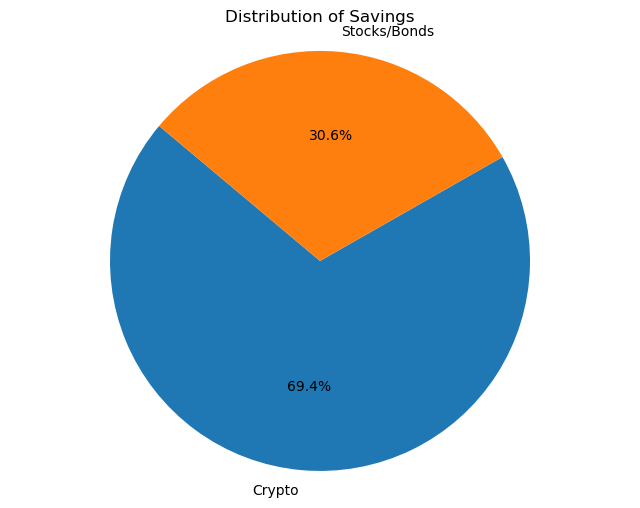

In [15]:
# Plot savings pie chart
plt.figure(figsize=(8, 6))
plt.pie(df_savings.iloc[0], labels=df_savings.columns, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Savings')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


In [16]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = crypto_wallet_value + stock_bond_value + emergency_fund

# Validate saving health
if total_savings >= emergency_fund:
    print("Your emergency fund is fully funded. Good job!")
else:
    print("Your emergency fund is not fully funded. Consider saving more to reach the recommended amount.")

Your emergency fund is fully funded. Good job!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [17]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [18]:
# Get 5 years' worth of historical data for SPY and AGG
df_ticker = api.get_bars(tickers, timeframe, start=start_date, end=end_date).df

# Reorganize the DataFrame
# Separate ticker data
# Create separate DataFrames for SPY and AGG
SPY= df_ticker[df_ticker['symbol'] == 'SPY'].drop('symbol', axis=1)
AGG = df_ticker[df_ticker['symbol'] == 'AGG'].drop('symbol', axis=1)

# Print the first few rows of each DataFrame to verify
print("SPY Data:")
print(SPY.head())

print("\nAGG Data:")
print(AGG.head())


# Concatenate the ticker DataFrames

df_ticker = pd.concat([SPY, AGG], axis=1, keys=["SPY", "AGG"])
# Display sample data
df_ticker.head()

SPY Data:
                              close    high     low  trade_count    open  \
timestamp                                                                  
2016-05-02 04:00:00+00:00  207.9700  208.18  206.41       263586  206.92   
2016-05-03 04:00:00+00:00  206.1592  206.80  205.28       377523  206.52   
2016-05-04 04:00:00+00:00  205.0100  205.85  204.42       345266  204.99   
2016-05-05 04:00:00+00:00  204.9700  205.98  204.47       280626  205.56   
2016-05-06 04:00:00+00:00  205.7200  205.77  203.88       340162  204.06   

                              volume        vwap  
timestamp                                         
2016-05-02 04:00:00+00:00   64747229  207.305695  
2016-05-03 04:00:00+00:00  108050343  206.309997  
2016-05-04 04:00:00+00:00   94995641  205.086315  
2016-05-05 04:00:00+00:00   68425268  205.140615  
2016-05-06 04:00:00+00:00   90999800  204.943796  

AGG Data:
                             close      high       low  trade_count    open  \
timestamp 

SPY                                      \
                              close    high     low trade_count    open   
timestamp                                                                 
2016-05-02 04:00:00+00:00  207.9700  208.18  206.41      263586  206.92   
2016-05-03 04:00:00+00:00  206.1592  206.80  205.28      377523  206.52   
2016-05-04 04:00:00+00:00  205.0100  205.85  204.42      345266  204.99   
2016-05-05 04:00:00+00:00  204.9700  205.98  204.47      280626  205.56   
2016-05-06 04:00:00+00:00  205.7200  205.77  203.88      340162  204.06   

                                                      AGG                      \
                              volume        vwap    close      high       low   
timestamp                                                                       
2016-05-02 04:00:00+00:00   64747229  207.305695  110.605  110.7400  110.5200   
2016-05-03 04:00:00+00:00  108050343  206.309997  110.810  110.9450  110.7500   
2016-05-04 04:00:00+00:00   94995641  205.086315  110.860  110.9315  110.7595   
2016-05-05 04:00:00+00:00   68425268  205.140615  111.140  111.1600  110.8010   
2016-05-06 04:00:00+00:00   90999800  204.943796  110.970  111.1200  110.9700   

                                                                    
                          trade_count    open   volume        vwap  
timestamp                                                           
2016-05-02 04:00:00+00:00       15122  110.74  3608552  110.626939  
2016-05-03 04:00:00+00:00       15663  110.89  3128774  110.864495  
2016-05-04 04:00:00+00:00       13984  110.91  3096337  110.877983  
2016-05-05 04:00:00+00:00       15708  110.92  3052967  111.030002  
2016-05-06 04:00:00+00:00       12697  111.12  2922700  111.027631

In [19]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30year = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.60,.40],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [20]:
# Printing the simulation input data
MC_30year.portfolio_data.head()

SPY                                      \
                              close    high     low trade_count    open   
timestamp                                                                 
2016-05-02 04:00:00+00:00  207.9700  208.18  206.41      263586  206.92   
2016-05-03 04:00:00+00:00  206.1592  206.80  205.28      377523  206.52   
2016-05-04 04:00:00+00:00  205.0100  205.85  204.42      345266  204.99   
2016-05-05 04:00:00+00:00  204.9700  205.98  204.47      280626  205.56   
2016-05-06 04:00:00+00:00  205.7200  205.77  203.88      340162  204.06   

                                                                   AGG  \
                              volume        vwap daily_return    close   
timestamp                                                                
2016-05-02 04:00:00+00:00   64747229  207.305695          NaN  110.605   
2016-05-03 04:00:00+00:00  108050343  206.309997    -0.008707  110.810   
2016-05-04 04:00:00+00:00   94995641  205.086315    -0.005574  110.860   
2016-05-05 04:00:00+00:00   68425268  205.140615    -0.000195  111.140   
2016-05-06 04:00:00+00:00   90999800  204.943796     0.003659  110.970   

                                                                            \
                               high       low trade_count    open   volume   
timestamp                                                                    
2016-05-02 04:00:00+00:00  110.7400  110.5200       15122  110.74  3608552   
2016-05-03 04:00:00+00:00  110.9450  110.7500       15663  110.89  3128774   
2016-05-04 04:00:00+00:00  110.9315  110.7595       13984  110.91  3096337   
2016-05-05 04:00:00+00:00  111.1600  110.8010       15708  110.92  3052967   
2016-05-06 04:00:00+00:00  111.1200  110.9700       12697  111.12  2922700   

                                                    
                                 vwap daily_return  
timestamp                                           
2016-05-02 04:00:00+00:00  110.626939          NaN  
2016-05-03 04:00:00+00:00  110.864495     0.001853  
2016-05-04 04:00:00+00:00  110.877983     0.000451  
2016-05-05 04:00:00+00:00  111.030002     0.002526  
2016-05-06 04:00:00+00:00  111.027631    -0.001530

In [21]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000622,1.000439,0.998270,0.997216,1.008710,1.007725,0.992282,1.003643,1.018105,1.002590,...,0.992772,0.993229,1.002619,0.999703,0.985138,0.998311,1.000781,1.012427,1.002660,0.990071
2,1.001963,0.995650,1.003802,0.976715,1.002776,1.002693,0.987427,1.005918,1.019140,0.997919,...,0.991805,0.998636,0.990515,1.010660,0.994115,1.001512,0.993799,1.002508,1.021609,0.999631
3,1.014439,0.996749,0.987158,0.981788,1.016478,0.999862,0.989375,1.006253,1.030513,1.001761,...,0.988820,0.986221,0.991654,1.010966,0.992408,1.003466,1.007693,0.994104,1.030149,0.997425
4,1.018910,0.993640,0.974514,0.984114,1.004964,1.009836,0.993097,1.003828,1.037426,0.997138,...,0.999264,0.989569,0.998519,1.004208,1.006567,0.989608,1.007688,0.992256,1.036927,0.996226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,31.621364,9.559445,17.802767,10.211096,20.665420,13.490613,13.857041,46.078208,15.107819,31.852347,...,25.402052,58.269762,2.644534,15.947720,13.509603,8.642148,9.998643,22.679032,5.631797,6.685572
7557,31.705423,9.716246,17.970255,10.182073,20.582812,13.561775,13.844969,46.061502,15.046350,32.002961,...,25.711276,58.369486,2.635428,16.060545,13.455537,8.548430,10.005432,22.565501,5.621338,6.744894
7558,31.782021,9.739367,17.917937,10.205210,20.546822,13.484638,13.903625,46.537559,14.960402,32.038526,...,25.547652,58.319652,2.605351,16.088630,13.443173,8.492764,10.028388,22.871002,5.624209,6.761166
7559,31.837641,9.767309,17.822629,10.154021,20.359472,13.293197,13.998076,46.446739,15.018465,32.101388,...,25.551839,59.099948,2.619415,16.254043,13.557175,8.497040,10.055921,22.720814,5.654548,6.791202


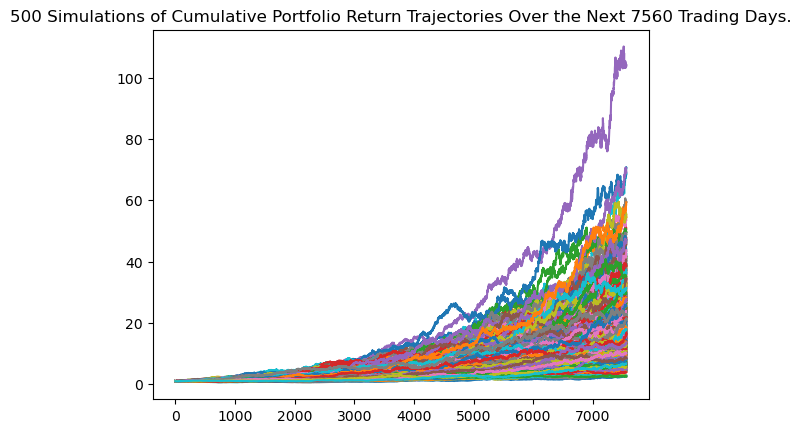

In [22]:
# Plot simulation outcomes
line_plot = MC_30year.plot_simulation()
# Save the plot for future usage
line_plot.get_figure().savefig("MC_30year_sim_plot.png", bbox_inches="tight")

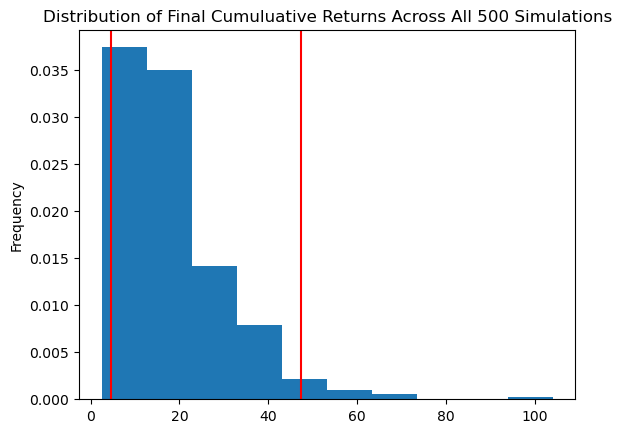

In [23]:
# Plot probability distribution and confidence intervals
dist_plot = MC_30year.plot_distribution()
# Save the plot for future usage
dist_plot.get_figure().savefig('MC_30year_dist_plot.png',bbox_inches='tight')

### Retirement Analysis

In [37]:
# Fetch summary statistics from the Monte Carlo simulation results

# Get the DataFrame of simulated returns
simulated_returns_data = MC_30year.simulated_return

# Calculate summary statistics
tbl = simulated_returns_data.describe()

# Calculate 95% confidence interval
ci_lower = simulated_returns_data.quantile(0.025)
ci_upper = simulated_returns_data.quantile(0.975)

# Print summary statistics
print(tbl)
print("95% CI Lower:", ci_lower)
print("95% CI Upper:", ci_upper)


               0            1            2            3            4    \
count  7561.000000  7561.000000  7561.000000  7561.000000  7561.000000   
mean      8.689970     4.579443     4.629684     2.934678     5.931831   
std       7.679424     2.697986     4.511528     2.369435     4.516699   
min       0.976889     0.898974     0.955031     0.779080     0.977785   
25%       2.637463     2.402832     1.344792     1.344516     2.109036   
50%       5.743642     4.401387     2.863127     2.020809     4.129412   
75%      11.984079     7.374960     5.380028     3.470922    10.187215   
max      32.455373    10.204308    18.465370    11.271500    21.061581   

               5            6            7            8            9    ...  \
count  7561.000000  7561.000000  7561.000000  7561.000000  7561.000000  ...   
mean      4.479076     5.712414    12.187000     6.173587    10.431542  ...   
std       3.499005     4.415483    12.456832     4.864816     9.814822  ...   
min       0.89824

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [42]:
# Set initial investment
initial_investment = 20000

# Calculate the portfolio return at 95% confidence interval lower bound
portfolio_return_lower = initial_investment * ci_lower

# Calculate the portfolio return at 95% confidence interval upper bound
portfolio_return_upper = initial_investment * ci_upper

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${portfolio_return_lower:.2f} and ${portfolio_return_upper:.2f}")



There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $3024400000000.00 and $3024400000000.00


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [43]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
# Calculate the portfolio return at 95% confidence interval lower bound
portfolio_return_lower = initial_investment * ci_lower

# Calculate the portfolio return at 95% confidence interval upper bound
portfolio_return_upper = initial_investment * ci_upper

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${portfolio_return_lower:.2f} and ${portfolio_return_upper:.2f}")


There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $4536600000000.00 and $4536600000000.00


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [27]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [28]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [29]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [30]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [31]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [32]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

NameError: name 'ci_lower_five' is not defined

### Ten Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")